DOG AND CAT CLASSIFIER USING CONVNETS & DATA AUGMENTATION

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Dataset download from microsoft site to local temp directory - it might take few minutes
os.mkdir("/tmp")
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-08-16 18:31:06--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.33.137.47
Connecting to download.microsoft.com (download.microsoft.com)|23.33.137.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: '/tmp/cats-and-dogs.zip'

     0K .......... .......... .......... .......... ..........  0%  426K 31m31s
    50K .......... .......... .......... .......... ..........  0%  509K 28m57s
   100K .......... .......... .......... .......... ..........  0%  667K 26m1s
   150K .......... .......... .......... .......... ..........  0%  646K 24m42s
   200K .......... .......... .......... .......... ..........  0% 1,39M 21m39s
   250K .......... .......... .......... .......... ..........  0% 1,99M 19m8s
   300K .......... .......... .......... .......... ..........  0% 1,95M 17m22s
   

In [3]:
#File cleaning
source_path = '/tmp/PetImages'
source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')
# Deletes all non-image files (there are two .db files bundled into the dataset)
path1 = os.path.join(source_path_dogs,'Thumbs.db')
path2 = os.path.join(source_path_cats,'Thumbs.db')
if os.path.exists(path1):
    os.remove(path1)
if os.path.exists(path2):
    os.remove(path2)
# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [4]:
# function to create train and test set directories
root_dir = '/tmp/cats-v-dogs'
# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
    os.makedirs(os.path.join(root_path,'training'))
    os.makedirs(os.path.join(root_path,'validation'))  
    os.makedirs(os.path.join(root_path,'training/cats'))
    os.makedirs(os.path.join(root_path,'training/dogs'))
    os.makedirs(os.path.join(root_path,'validation/cats'))
    os.makedirs(os.path.join(root_path,'validation/dogs'))
    
try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")


In [9]:
# Split data into train and test sets
# SOURCE_DIR (string): directory path containing the images
# TRAINING_DIR (string): directory path to be used for training
# SPLIT_SIZE (float): proportion of the dataset to be used for training

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE_DIR):
        file_name = os.path.join(SOURCE_DIR, filename)
        if os.path.getsize(file_name) > 0:
            files.append(filename)
        else:
            print("{} has zero length so discarding".format(filename))
    train_set_size = int(len(files)*SPLIT_SIZE)
    shuffled_data = random.sample(files, len(files))
    training_data = shuffled_data[0:train_set_size]
    testing_data = shuffled_data[train_set_size:len(files)]

    for file in training_data:
        src_file = os.path.join(SOURCE_DIR, file)
        des_file = os.path.join(TRAINING_DIR, file)
        copyfile(src_file, des_file)
    for file in testing_data:
        src_file = os.path.join(SOURCE_DIR, file)
        des_file = os.path.join(VALIDATION_DIR, file)
        copyfile(src_file, des_file)    


In [10]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
    for file in os.scandir(VALIDATION_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
    for file in os.scandir(VALIDATION_DOGS_DIR):
        os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")


666.jpg has zero length so discarding
11702.jpg has zero length so discarding


There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [11]:
# Training and Validation Data Generators
# TRAINING_DIR (string): directory path containing the training images
# VALIDATION_DIR (string): directory path containing the testing/validation images
# returns: train_generator, validation_generator - tuple containing the generators

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

    validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=20,
                                                                  class_mode='binary',
                                                                  target_size=(150, 150))
    return train_generator, validation_generator


In [12]:
# Testing generators
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [13]:
# Model Construction
# CREATE A KERAS MODEL TO CLASSIFY CATS V DOGS WITH 4 CONV LAYERS

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'), 
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])

    model.compile(optimizer='adam',    
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 

    return model


In [14]:
#Training the model (it might take some time)
model = create_model()
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
 548/1125 [=============>................] - ETA: 3:16 - loss: 0.6847 - accuracy: 0.5536

C:\Users\Boris-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 [==============================] - 401s 356ms/step - loss: 0.6708 - accuracy: 0.5808 - val_loss: 0.6320 - val_accuracy: 0.6476
Epoch 2/15
1125/1125 [==============================] - 353s 314ms/step - loss: 0.6016 - accuracy: 0.6758 - val_loss: 0.5738 - val_accuracy: 0.7068
Epoch 3/15
1125/1125 [==============================] - 345s 307ms/step - loss: 0.5600 - accuracy: 0.7130 - val_loss: 0.5261 - val_accuracy: 0.7404
Epoch 4/15
1125/1125 [==============================] - 350s 311ms/step - loss: 0.5244 - accuracy: 0.7370 - val_loss: 0.4565 - val_accuracy: 0.7972
Epoch 5/15
1125/1125 [==============================] - 359s 319ms/step - loss: 0.5048 - accuracy: 0.7552 - val_loss: 0.4360 - val_accuracy: 0.7908
Epoch 6/15
1125/1125 [==============================] - 349s 310ms/step - loss: 0.4760 - accuracy: 0.7719 - val_loss: 0.4146 - val_accuracy: 0.8056
Epoch 7/15
1125/1125 [==============================] - 349s 310ms/step - loss: 0.4477 - accuracy: 0.7878 - val_loss: 0.380

1/1 [==============================] - 0s 38ms/step
[0.02228858]
images/Gato1.jpg is a cat


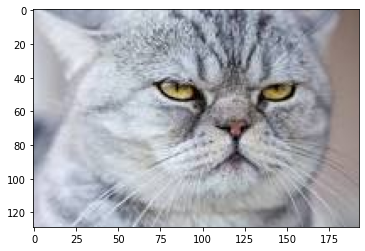

In [49]:
## WRITE YOUR OWN PATH ACCORDING TO YOUR DOG/CAT IMAGE FILE LOCATION

import matplotlib.image as mpimg
path='images/Gato1.jpg'
img = mpimg.imread(path)
plt.imshow(img)

from tensorflow.keras.preprocessing import image
import numpy as np
img=image.load_img(path, target_size=(150, 150))
x=image.img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=10)
  
print(classes[0])
if classes[0]>0.5:
    print(path + " is a dog")
else:
    print(path + " is a cat")